# Model Selection

Notebook to plot and analyse training results to select best models and corresponding model and dataset hyperparameters  
  
The first selecting criteria are the best cross-epoch results which are the averaged performances of the best models resulting from each folds.  (cell 'Best Epoh > Cross Epochs')  

Other point taken into account in the selection :    
- smoothness of the validation curve (cell 'Validation Curve')   
  (highly volatile validation curves might suggest lucky and less generalisable best results)    
- correlation of the training and validation curve (cells 'Training vs Validation')   
  (when the training and validation compositions is similar the curves   
   should be correlated up to the overfitting point,  
   however it is not the case for different weights and composition between training and validation,  
   in such cases the comparison between both curves is harder to interpret and less valuable)

# Config

In [ ]:
COLAB = False

if COLAB : 
  configSetup = {
      'COLAB'           : 'True',
      'PATH_ROOT_DRIVE' : '/content/drive/MyDrive/Projects/Forecast',
      'PATH_ROOT_LOCAL' : '/content/session',
      'PATH_SUNDL'      : '/content/sundl',
      'PATH_PROJECT'    : '/content/sundl/notebooks/flare_limits_pcnn'
  }
  !git clone https://github.com/gfrancisco20/sundl.git
  import sys
  import re
  sys.path.append(configSetup['PATH_SUNDL'])
  sys.path.append(configSetup['PATH_PROJECT'])
  configFile = f'{configSetup["PATH_PROJECT"]}/config.py'
  with open(configFile, 'r') as file:
    content = file.read()
  for constant in configSetup.keys():
    content = re.sub(re.compile(f'{constant} = .*'), f'{constant} = \'{configSetup[constant]}\'', content)
  with open(configFile, 'w') as file:
    file.write(content)
   
from config import *
from sundl.utils.colab import mountDrive
if COLAB:
  # mouting drive content in session on colab
  mountDrive()

# Libraries

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from ipywidgets import interact


# Setup

In [8]:
FOLDER = PATH_RES/'Results_Paper_PCNN' #'Classification_02_24h_SC25_Paper_CV5_CV05_2023_11_06__0'

sortingMtc = 'val_tss'

epochLim = None

plotByNumInst = False # --> to compare models trained on sets of different sizes
if plotByNumInst:
  xaxisID = 'num_train_inst'
else:
  xaxisID = 'epoch'

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,8)

# Load CV Results

In [9]:
best = pd.read_csv(FOLDER/'bests.csv').sort_values(by=[sortingMtc],ascending=False)
bestCvCrEpcPath = FOLDER/'bestsCVCrossEpoch.csv'
HAS_CV = False
bestCVCrossEpoch =  None
if bestCvCrEpcPath.exists():
  bestCVCrossEpoch = pd.read_csv(bestCvCrEpcPath).sort_values(by=[sortingMtc],ascending=False)
  HAS_CV = True

list_metrics = [col for col in list(best.columns) if (col != 'model' and col[0:2]!='va' and col[-2:] not in ['pc','td','in','ax','st'])]
list_metrics_vals = [f'val_{col}' for col in list_metrics]

models = list(best['model'])

res = {}
for model in models:
  if epochLim is not None:
    res[model] =  pd.read_csv((FOLDER/f'training_{model}.csv').as_posix()).loc[0:epochLim]
  else:
    res[model] =  pd.read_csv((FOLDER/f'training_{model}.csv').as_posix())
  
# normalisation of the xaxis for model with different number of trained instances
if plotByNumInst:
  # axis calculation
  xaxis = []
  for model in models:
    xaxis = xaxis + list(res[model][xaxisID].values)
  xaxis = sorted(set(xaxis))
  # rows insertions
  complementaryRows = {num_inst : dict(**{col : np.nan for col in res[models[0]].columns if col != xaxisID}, **{xaxisID:num_inst}) for num_inst in xaxis}
  for model in models:
    for num_inst in xaxis:
      if num_inst not in res[model][xaxisID].values:
        res[model] = res[model].append(complementaryRows[num_inst], ignore_index=True)
    res[model].sort_values(by=[xaxisID], ascending=True, inplace=True, ignore_index=True)
    res[model].set_index(xaxisID ,inplace=True)

  # Interpolation
    res[model].interpolate(method='index', axis=0, limit_direction='forward', inplace = True)
    res[model]['epoch'] = res[model]['epoch'].fillna(np.max(res[model]['epoch'].fillna(-1))) # useless?
    res[model].reset_index(inplace=True)
    res[model][xaxisID] = res[model][xaxisID].astype('int64')
    res[model] = res[model].set_index(xaxisID)

# Result dataframes

In [10]:
viz_metrics = [
 'val_acc',
 'val_tss',
 'val_hss',
 'val_mcc',
 'val_f1',
 'val_recall',
 'val_precision',
 'val_auc_roc',
 'val_auc_pr',
 'val_far',
 'val_TP',
 'val_FN',
 'val_TN',
 'val_FP',
 'val_loss']

Model names structure is as followed :  
**{cls}\_{labelCol}\_{Archi}\_{Pretraining}\_{WeightStrategy}\_{Optimizer}\_{Input}\_{windowSize_h}**  

With : 
- **cls**         : the binary class threshold, e.g. 'C+'  
- **labelCol**    : the columns on which the classes are defined, e.g. 'mpf' or 'toteh' (fluence)  
- **Archi**       : model architecture, ex: 'PTx8' for a PCNN of 8 patches, 'FD' for a full-disk CNN (here an EffNetV2S)  
- **Pretraining** :   
  'FlTr'  -> no pretrained weight (random initial weight) ;  
  'Ptrd'  -> pretrained without retraining ;       
  'RtdXz' -> pretrained  and retrained for the last z layers (excluding batchnorm layers) 
- **WeightStrategy** : name of the weight strategy used on the training to penalise differently sub-cases of positiive and negative events
- **Optimizer**    : e.g. 'AW1e5D1e4' -> AdamW, lr 1e-5, weight_decay 1e-4
- **Input**        : e.g. 'blos','0193x0211x0094'
- **windowSize_h** : size of the time-windows on which aree compted the labels (in hours)

In [11]:
display(best[['model']+viz_metrics])#[:10]

model   val_acc   val_tss  \
0                                C+_mpf_Persistant_24  0.855476  0.711644   
1   C+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193x021...  0.831957  0.667164   
2   C+_mpf_FD_RtdX3_ProgPos_AW1e3D1e4_0193x0211x00...  0.819638  0.644850   
3           C+_mpf_FD_RtdX3_ProgPos_AW1e3D1e4_blos_24  0.814675  0.633987   
4                C+_mpf_FD_Ptrd_ProgPos_Am1e3_blos_24  0.814824  0.631854   
5       C+_mpf_PTx8_RtdXall_ProgPos_AW4e6D4e3_blos_24  0.808280  0.618567   
6            C+_mpf_FD_Ptrd_ProgPos_AW2e4D4e3_blos_24  0.805014  0.618311   
7     C+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_b_blos_24  0.804033  0.612769   
8   C+_mpf_PTx8xIntrPtc_RtdXall_ProgPos_AW1e5D4e3_...  0.805088  0.610745   
9       C+_mpf_PTx8_RtdXall_ProgPos_AW2e5D4e3_blos_24  0.801443  0.604129   
10     C+_mpf_FD_Ptrd_ProgPos_Am1e3_0193x0211x0094_24  0.796732  0.596932   
11      C+_mpf_PTx8_RtdXall_ProgPos_Aw1e5D1e4_blos_24  0.797671  0.595965   
12            C+_mpf_PTx8_RtdXall_LowBC_Am2e5_blos_24  0.797633  0.594679   
13  C+_mpf_PTx8_RtdXall_NoWghtxNatFold_Am2e5x25_bl...  0.795382  0.588384   
14             C+_mpf_PTx4_Ptrd_ProgPos_Am1e3_blos_24  0.789177  0.579380   
15        C+_mpf_PTx8_RtdXall_EquiC_AW2e5D4e3_blos_24  0.786577  0.569011   
16            C+_mpf_PTx8_RtdXall_EquiC_Am4e5_blos_24  0.785304  0.563442   
17  M+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193x021...  0.805753  0.560269   
18       C+_mpf_PTx8_RtdXall_NoWght_AW2e5D4e3_blos_24  0.778478  0.550329   
19         C+_mpf_PTx8_Ptrd_ProgPos_AW1e4D1e4_blos_24  0.756385  0.521086   
20                               M+_mpf_Persistant_24  0.878405  0.473592   
21        M+_mpf_PTx8_RtdXall_LowC2_AW8e6D1e3_blos_24  0.792084  0.459155   
22         M+_mpf_PTx8_RtdXall_LowC_AW6e6D1e3_blos_24  0.803345  0.441562   
23   M+_mpf_PTx8_RtdXall_LowC2_AW1e5D1e4_tfix_blos_24  0.798638  0.436927   
24        M+_mpf_PTx8_RtdXall_LowC2_AW1e5D1e4_blos_24  0.817943  0.435882   
25      M+_mpf_PTx8_RtdXall_LowC2_AW6e6D4e3_b_blos_24  0.801206  0.432080   
26      M+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_blos_24  0.840148  0.430718   
27   M+_mpf_PTx8_RtdXall_LowC2_AW1e5D1e4_hOpt_blos_24  0.803265  0.422093   
28    M+_mpf_PTx8_RtdXall_LowC_AW1e5D1e4_hOpt_blos_24  0.823652  0.421329   
29      M+_mpf_PTx8_RtdXall_ProgPos_AW2e5D4e3_blos_24  0.844972  0.412831   
30   M+_mpf_PTx8_RtdXall_LowC2_AW6e6D1e3_hOpt_blos_24  0.812593  0.402691   
31    M+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_b_blos_24  0.820363  0.362152   
32        M+_mpf_PTx8_RtdXall_EquiM_AW8e6D1e3_blos_24  0.857842  0.303133   
33        M+_mpf_PTx8_RtdXall_EquiM_AW1e5D1e6_blos_24  0.863175  0.265902   
34  C+_mpf_FD_RtdXall_ProgPos_Aw1e5D1e4_0193x0211x...  0.612293  0.258163   
35                               X+_mpf_Persistant_24  0.978684  0.187749   

     val_hss   val_mcc    val_f1  val_recall  val_precision  val_auc_roc  \
0   0.710670  0.712630  0.850302    0.863389       0.839748     0.855476   
1   0.664497  0.667742  0.830615    0.998923       0.824290     0.881874   
2   0.640513  0.651262  0.821233    0.886390       0.817736     0.887655   
3   0.630527  0.641935  0.815592    0.906677       0.806816     0.881170   
4   0.629732  0.640004  0.808082    0.861209       0.813443     0.880879   
5   0.616787  0.619483  0.807860    0.996592       0.796374     0.857171   
6   0.612748  0.627544  0.816894    0.999789       0.742499     0.822825   
7   0.609459  0.616551  0.807455    0.998940       0.793824     0.862184   
8   0.609826  0.613399  0.797040    0.993460       0.814874     0.869594   
9   0.602793  0.607066  0.798384    0.949040       0.808209     0.857930   
10  0.593170  0.611790  0.789252    0.838535       0.789700     0.872295   
11  0.595110  0.596502  0.793466    0.994515       0.800849     0.854055   
12  0.594470  0.598838  0.786381    0.785331       0.865709     0.864120   
13  0.589218  0.592648  0.780597    0.766037       0.899126     0.861924   
14  0.578409  0.583537  0.785951    0.840323       0.77078

In [12]:
if bestCVCrossEpoch is not None:
  display(bestCVCrossEpoch[['model']+viz_metrics])#[:10])

model   val_acc   val_tss  \
0                                C+_mpf_Persistant_24  0.855476  0.711644   
1   C+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193x021...  0.839091  0.678765   
2   C+_mpf_FD_RtdX3_ProgPos_AW1e3D1e4_0193x0211x00...  0.831113  0.664300   
3           C+_mpf_FD_RtdX3_ProgPos_AW1e3D1e4_blos_24  0.825781  0.653238   
4                C+_mpf_FD_Ptrd_ProgPos_Am1e3_blos_24  0.820998  0.644902   
5            C+_mpf_FD_Ptrd_ProgPos_AW2e4D4e3_blos_24  0.815476  0.638544   
6   C+_mpf_PTx8xIntrPtc_RtdXall_ProgPos_AW1e5D4e3_...  0.817590  0.636188   
7       C+_mpf_PTx8_RtdXall_ProgPos_AW2e5D4e3_blos_24  0.816603  0.635458   
8       C+_mpf_PTx8_RtdXall_ProgPos_AW4e6D4e3_blos_24  0.815175  0.632319   
9     C+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_b_blos_24  0.812844  0.628496   
10      C+_mpf_PTx8_RtdXall_ProgPos_Aw1e5D1e4_blos_24  0.808866  0.619577   
11     C+_mpf_FD_Ptrd_ProgPos_Am1e3_0193x0211x0094_24  0.806766  0.618394   
12            C+_mpf_PTx8_RtdXall_LowBC_Am2e5_blos_24  0.808026  0.614004   
13  C+_mpf_PTx8_RtdXall_NoWghtxNatFold_Am2e5x25_bl...  0.804303  0.608408   
14             C+_mpf_PTx4_Ptrd_ProgPos_Am1e3_blos_24  0.803010  0.608361   
15            C+_mpf_PTx8_RtdXall_EquiC_Am4e5_blos_24  0.802471  0.602215   
16        C+_mpf_PTx8_RtdXall_EquiC_AW2e5D4e3_blos_24  0.799613  0.597080   
17  M+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193x021...  0.832524  0.593203   
18       C+_mpf_PTx8_RtdXall_NoWght_AW2e5D4e3_blos_24  0.791850  0.579558   
19         C+_mpf_PTx8_Ptrd_ProgPos_AW1e4D1e4_blos_24  0.763494  0.534851   
20      M+_mpf_PTx8_RtdXall_LowC2_AW6e6D4e3_b_blos_24  0.817349  0.490523   
21        M+_mpf_PTx8_RtdXall_LowC2_AW1e5D1e4_blos_24  0.826350  0.485038   
22    M+_mpf_PTx8_RtdXall_LowC_AW1e5D1e4_hOpt_blos_24  0.833188  0.480141   
23   M+_mpf_PTx8_RtdXall_LowC2_AW1e5D1e4_tfix_blos_24  0.819542  0.478707   
24   M+_mpf_PTx8_RtdXall_LowC2_AW6e6D1e3_hOpt_blos_24  0.821944  0.476232   
25        M+_mpf_PTx8_RtdXall_LowC2_AW8e6D1e3_blos_24  0.811917  0.474263   
26                               M+_mpf_Persistant_24  0.878405  0.473592   
27      M+_mpf_PTx8_RtdXall_ProgPos_AW2e5D4e3_blos_24  0.858079  0.471792   
28         M+_mpf_PTx8_RtdXall_LowC_AW6e6D1e3_blos_24  0.812960  0.471670   
29      M+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_blos_24  0.847816  0.462365   
30   M+_mpf_PTx8_RtdXall_LowC2_AW1e5D1e4_hOpt_blos_24  0.827190  0.460736   
31    M+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_b_blos_24  0.831436  0.418595   
32        M+_mpf_PTx8_RtdXall_EquiM_AW8e6D1e3_blos_24  0.863609  0.335541   
33        M+_mpf_PTx8_RtdXall_EquiM_AW1e5D1e6_blos_24  0.864283  0.323937   
34  C+_mpf_FD_RtdXall_ProgPos_Aw1e5D1e4_0193x0211x...  0.646509  0.323499   
35                               X+_mpf_Persistant_24  0.978684  0.187749   

     val_hss   val_mcc    val_f1  val_recall  val_precision  val_auc_roc  \
0   0.710670  0.712630  0.850302    0.863389       0.839748     0.855476   
1   0.677734  0.680044  0.835295    0.999351       0.844828     0.887416   
2   0.662229  0.666225  0.827938    0.936934       0.878831     0.900507   
3   0.651596  0.657489  0.825506    0.944369       0.870257     0.896163   
4   0.642291  0.650854  0.818120    0.883618       0.843921     0.894921   
5   0.633304  0.646475  0.825830    1.000000       0.834047     0.853499   
6   0.634816  0.637540  0.816333    0.993460       0.847477     0.878382   
7   0.633586  0.635435  0.815586    0.949040       0.854732     0.872989   
8   0.630627  0.632088  0.815371    0.998069       0.815554     0.861551   
9   0.626264  0.629126  0.813312    0.998940       0.812031     0.864575   
10  0.617998  0.621093  0.810294    0.995781       0.825293     0.863255   
11  0.614480  0.625837  0.806347    0.876230       0.804551     0.873560   
12  0.614511  0.617541  0.796117    0.937411       0.893720     0.875059   
13  0.607762  0.609994  0.797041    0.887897       0.946401     0.869034   
14  0.606366  0.613302  0.809266    0.908416       0.82016

# Best Epoch - Comparisons

## Standard

For C+_EUV ; C+_Blos ; and M+_EUV we select the best cross-epoch model (c.f. next plot)  
The M+_Blos was harder to tune and many of the tried parameters lead to similar performances.  
We select the M+_mpf_PTx8_RtdXall_LowC_AW6e6D1e3_blos_24 model.  
It is not the one with the best TSS but it is close to the best one with a better HSS and MCC than most and smoother learning curves.  
The smoother learning curves in particular might indicate a better generalisation ability (validation performance less likely to be attributed to random luck) 

Text(0.5, 0.94, 'Models : PCNN - FD -  Peristent\n(err=std)')

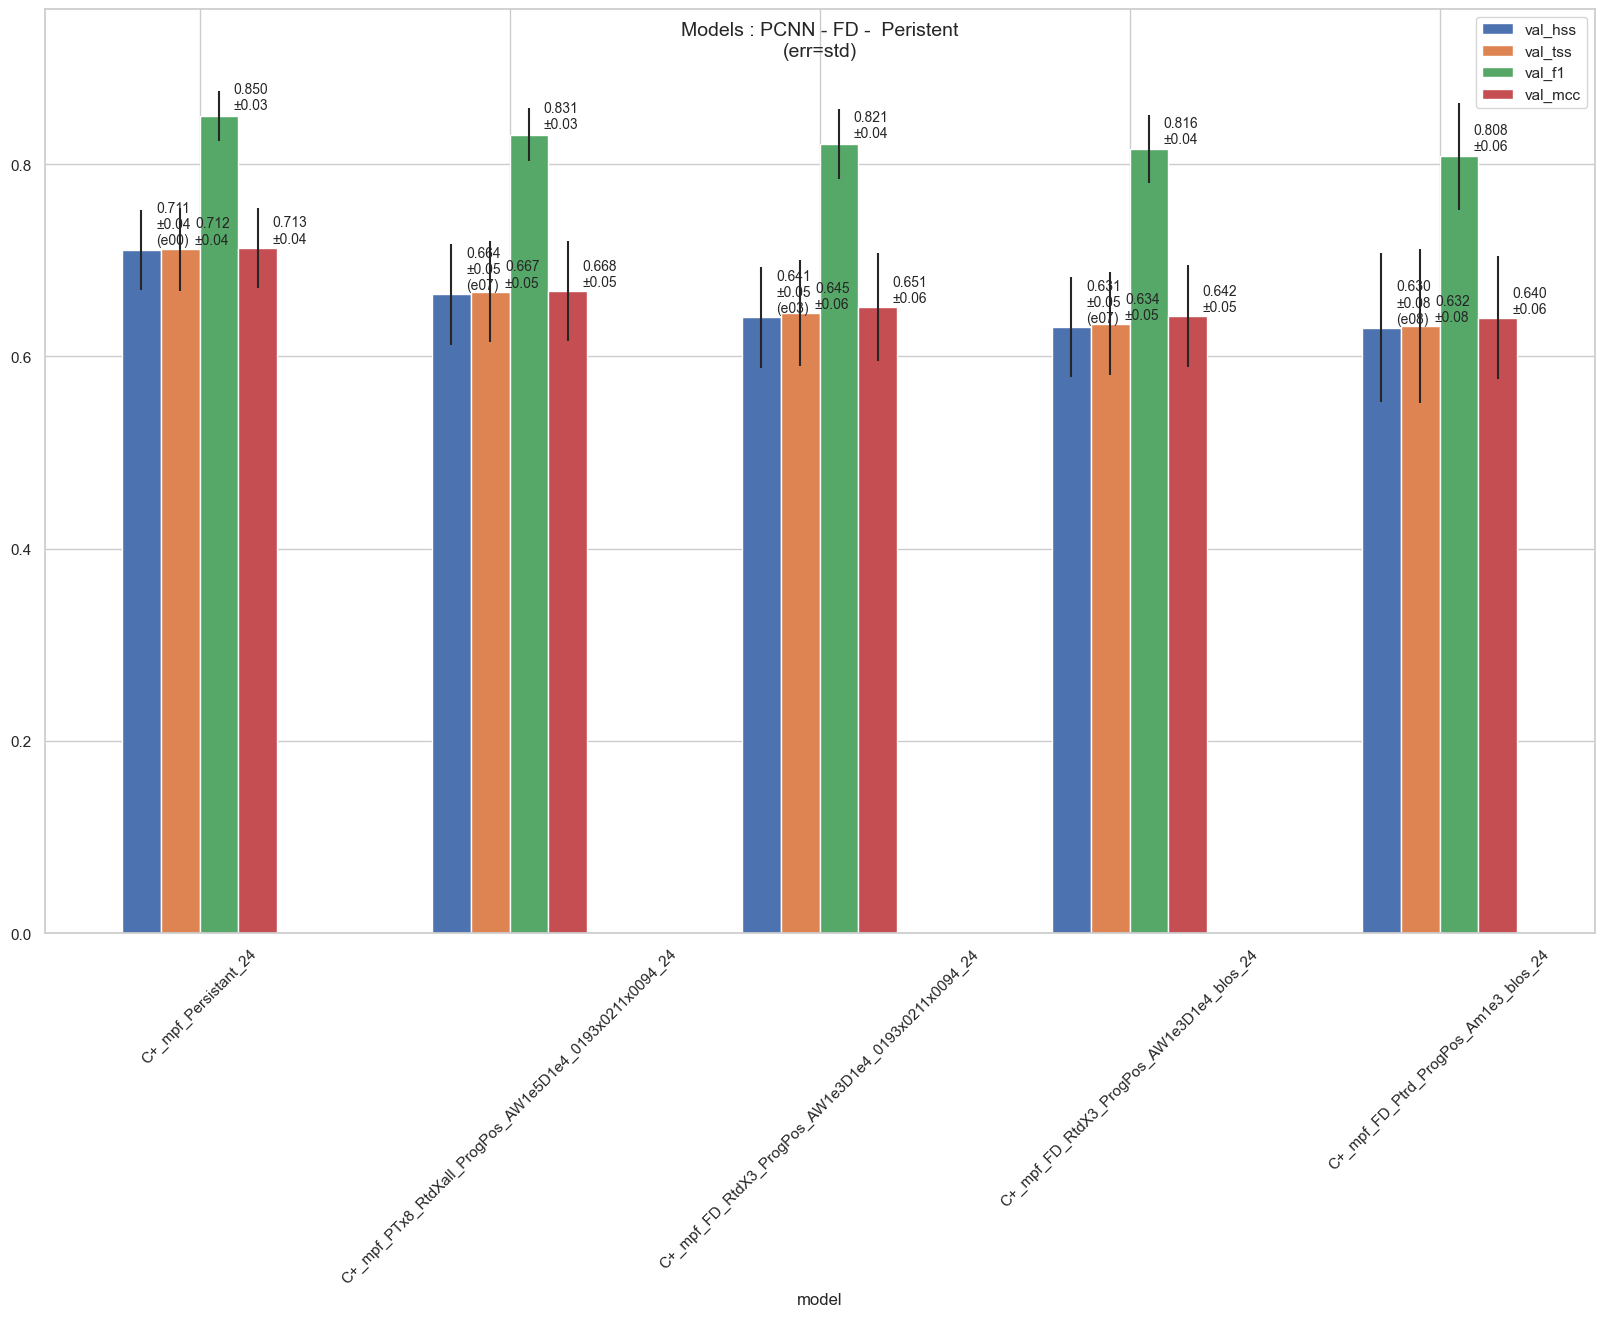

In [37]:
types    = ['C+']#, 'M+', 'X+'] # ['C+', 'M+', 'X+']
hasCV    = HAS_CV
metrics  = ['val_hss','val_tss', 'val_f1', 'val_mcc'] # ['val_tss','val_far']
pltBest  = [True     , False   , False   , False]
err_type = 'std' # 'std' , 'minmax'
kind     = "bar"
num_top  = 5
archis   = 'PCNN - FD -  Peristent'


tmp = best.copy()
for i in range(len(tmp)):
  name_elems = tmp.loc[i]['model'].split('_')
  # if len(name_elems) > 2:
  #   best.loc[i,'model'] = f'{name_elems[0]}_{name_elems[1]}\n{name_elems[2]}'

tmp['type'] = tmp['model'].apply(lambda x: x[:2])
tmp = tmp[tmp['type'].isin(types)]
if num_top is None: num_top = len(tmp)
tmp = tmp[0:num_top]
sub_models = tmp['model'].values

if not hasCV:
  yerr=None
else:
  if err_type == 'minmax': err_type = ('min','max')
  if type(err_type) in [tuple,list]:
    yerr=[[tmp[metrics[i]+'_'+err_type[0]]-tmp[metrics[i]],tmp[metrics[i]]+'_'+err_type[1]]-tmp[metrics[i]] for i in range(len(metrics))]
    yerr = np.abs(yerr)
  else:
    yerr=[tmp[metrics[i]+'_'+err_type] for i in range(len(metrics))]
    # best[metrics[0]+'_'+err_type], best[metrics[1]+'_'+err_type]

tmp.set_index('model',inplace=True)
ax = tmp[metrics].\
        plot(kind=kind,figsize=(20, 12),yerr=yerr)

refEpochs = {}
for idx,p in enumerate(ax.patches):
  #print(f'{idx: >2} : {p.get_height():.2f}')
  mtcIdx = idx // len(sub_models)
  modIdx = idx % len(sub_models)
  takeBest = pltBest[mtcIdx]
  if takeBest:
    # else -> take epoch of the reference metric
    if metrics[mtcIdx][-3:] in ['loss','far','mae','mse','rmse','maep']:
      epoch = np.argmin(res[sub_models[modIdx]][metrics[mtcIdx]])
    else:
      epoch = np.argmax(res[sub_models[modIdx]][metrics[mtcIdx]])
    refEpochs[sub_models[modIdx]] = epoch
  else:
    epoch = refEpochs[sub_models[modIdx]]
  if hasCV:
    model = sub_models[modIdx]
    if type(err_type) in [tuple,list]:
      name_elems = model.split('_')
      if name_elems > 2:
        model = f'{name_elems[0]}_{name_elems[1]}\n{name_elems[2]}'
      low = tmp.loc[model][metrics[mtcIdx]+'_'+err_type[0]]
      up  = tmp.loc[model][metrics[mtcIdx]+'_'+err_type[1]]
      errstr = f'\n<{low:.2f};\n   {up:.2f}>'
    else:
      std = tmp.loc[model][metrics[mtcIdx]+'_'+err_type]
      errstr = f'\n±{std:.2f}'
  else:
    errstr = ''
  if kind == "barh":
    ax.annotate(f'{p.get_width():.2f} ({epoch})', (p.get_width() * 1.005, p.get_y() + p.get_height()/4))
  elif kind == "bar":
    shift = p.get_width()*0.88 if hasCV else 0
    epctag = f'\n(e{epoch:0>2})' if takeBest else ''
    ax.annotate(f'{p.get_height():.3f}{errstr}{epctag}', (p.get_x() + shift, p.get_height() * 1.008), fontsize=10)
    #ax.annotate(f'{p.get_height():.2f}\n({epoch})', (p.get_x() * 1.005 - 0.005* (p.get_x() / base - 1), p.get_height() * 1.008), fontsize=12)
ax.set_ylim((ax.get_ylim()[0],ax.get_ylim()[1]*1.045))
plt.xticks(rotation=45)
ypos = 0.94 if hasCV else 0.96
extratitle = f'\n(err={str(err_type)})' if hasCV else ''
plt.title(f'Models : {archis}{extratitle}', y = ypos, fontsize=14)


## Cross Epochs CV

The actual model selection must be made on cross-epoch CV results, as our final models are the ensembles of the models of each fold selected at their best epoch.

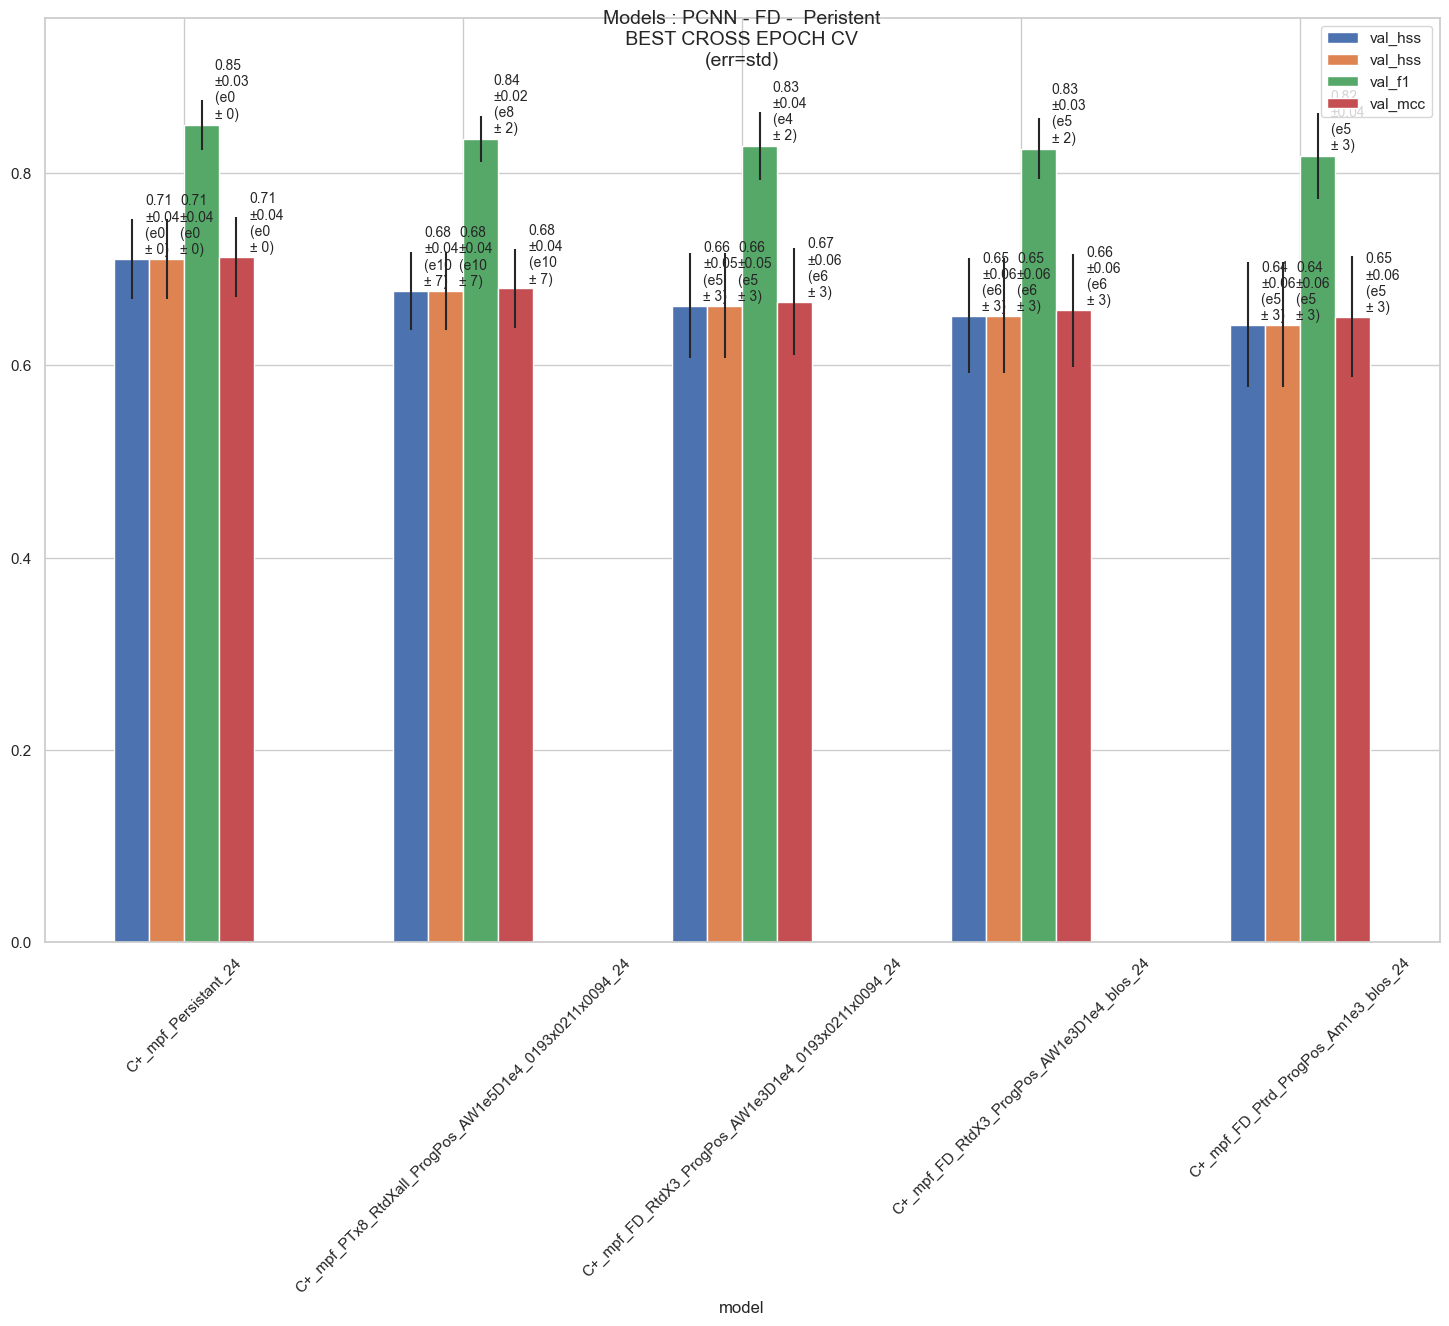

In [36]:
types    = ['C+']
hasCV    = True
metrics  = ['val_hss', 'val_hss','val_f1','val_mcc'] #]
pltBest  = [True     , False,False]
err_type = 'std' # 'std' , 'minmax'
kind     = "bar"
num_top  = 5
archis   = 'PCNN - FD -  Peristent'



tmp = bestCVCrossEpoch.copy()

tmp['type'] = tmp['model'].apply(lambda x: x[:2])
tmp = tmp[tmp['type'].isin(types)]
if num_top is None: num_top = len(tmp)
tmp = tmp[0:num_top]
sub_models = tmp['model'].values

if not hasCV:
  print('No CV')
else:
  if type(num_top)==str: num_top = len(best)
  tmp = tmp.sort_values(by=[metrics[0]], ascending = False).set_index('model')
  models = list(tmp.index)

  if err_type == 'minmax': err_type = ('min','max')
  if type(err_type) in [tuple,list]:
    yerr=[[tmp[metrics[i]+'_'+err_type[0]]-tmp[metrics[i]],tmp[metrics[i]+'_'+err_type[1]]-tmp[metrics[i]]] for i in range(len(metrics))]
    yerr = np.abs(yerr)
  else:
    yerr=[tmp[metrics[i]+'_'+err_type]  for i in range(len(metrics))]
  ax = tmp[metrics].\
        plot(kind=kind,figsize=(18, 12),yerr=yerr)

  for idx,p in enumerate(ax.patches):
    #print(f'{idx: >2} : {p.get_height():.2f}')
    mtcIdx = idx // len(sub_models)
    modIdx = idx % len(sub_models)
    epoch = tmp.loc[sub_models[modIdx]][metrics[mtcIdx]+'_epcs']
    epoch = [int(float(e)) for e in epoch.split('x')]
    epoch = f'{np.round(np.mean(epoch)):.0f} \n± {np.round(np.std(epoch)):.0f}'
    if type(err_type) in [tuple,list]:
      low = tmp.loc[sub_models[modIdx]][metrics[mtcIdx]+'_'+err_type[0]]
      up  = tmp.loc[sub_models[modIdx]][metrics[mtcIdx]+'_'+err_type[1]]
      errstr = f'\n<{low:.2f};\n   {up:.2f}>'
    else:
      std = tmp.loc[sub_models[modIdx]][metrics[mtcIdx]+'_'+err_type]
      errstr = f'\n±{std:.2f}'
    if kind == "barh":
      ax.annotate(f'{p.get_width():.2f} ({epoch})', (p.get_width() * 1.005, p.get_y() + p.get_height()/4))
    elif kind == "bar":
      ax.annotate(f'{p.get_height():.2f}{errstr}\n(e{epoch:0>2})', (p.get_x() + p.get_width()*0.88, p.get_height() * 1.008), fontsize=10)
      #ax.annotate(f'{p.get_height():.2f}\n({epoch})', (p.get_x() * 1.005 - 0.005* (p.get_x() / base - 1), p.get_height() * 1.008), fontsize=12)
  ax.set_ylim((ax.get_ylim()[0],ax.get_ylim()[1]*1.045))
  tmp = tmp.reset_index()
  plt.xticks(rotation=45)
  ypos = 0.94 if hasCV else 0.96
  plt.title(f'Models : {archis}\n BEST CROSS EPOCH CV \n(err={str(err_type)})', y = ypos, fontsize=14) # val_tss_epcs val_tss_epcs


# Validation Curves - Comparison


In [33]:
types    = ['C+']
hasCV    = True
num_top  = 4
err_type = 'std' # # 'std' , 'minmax' (used for cv only)
alpherr  = 0.15
archis   = 'PCNN - FD -  Peristent'

metrics = ['loss'  ,'acc','auc_roc',
           'tss'   ,'f1' ,'hss',
           'recall','precision','far'
           ]

plt.figure(figsize=(19, 26))

num_metrics = len(metrics)
bestmtc = {}
bestepc = {}
for i in range(num_metrics):
  mtc = metrics[i]
  sub_models = [m for m in models if m[:2] in types]
  if num_top is None:
    num_top = len(sub_models)
  else:
    if num_top <= 0:
      num_top = len(sub_models)
  for idx,model in enumerate(sub_models[0:num_top]):
    if idx==0:
      #ax = plt.subplot(int(np.ceil(np.sqrt(num_metrics))), int(np.round(np.sqrt(num_metrics))), i + 1)
      # ax = plt.subplot(int(np.ceil(np.sqrt(num_metrics)))-1, int(np.round(np.sqrt(num_metrics)))+1, i + 1)
      ax = plt.subplot(int(len(metrics)//3), 3, i + 1)
      #ax = plt.subplot(int(np.round(np.sqrt(num_metrics))), int(np.ceil(np.sqrt(num_metrics))), i + 1)
    val = np.array(res[model]['val_'+mtc])
    if len(val[~np.isnan(val)])==0:
      print(f'WARNING : no data for {model} {metrics[i]}')
    else:
      ax.plot(res[model].index, val, label = model)
      if hasCV:
        if err_type == 'minmax': err_type = ('min','max')
        if type(err_type) in [tuple,list]:
          lower = np.array(res[model]['val_'+mtc+'_'+err_type[0]])
          upper = np.array(res[model]['val_'+mtc+'_'+err_type[1]])
          #lower = lower[~np.isnan(lower)]
          #upper = upper[~np.isnan(upper)]
        else:
          #yerr=best[metrics[0]+'_'+err_type], best[metrics[1]+'_'+err_type]
          err = np.array(res[model]['val_'+mtc+'_'+err_type])
          #err = err[~np.isnan(err)]
          lower = val - err
          upper = val + err
        ax.fill_between(
          range(len(val)),
          lower,
          upper,
          alpha=alpherr)
      val = val[~np.isnan(val)]
      if mtc in ['loss','far','mae','mse']:
        if idx==0:
          bestmtc[mtc] = np.min(val)
          bestepc[mtc] = np.argmin(val)
        else:
          if  np.min(val) < bestmtc[mtc]:
            bestmtc[mtc] = np.min(val)
            bestepc[mtc] = np.argmin(val)
        #if idx==num_metrics-1:
        ax.set_title(f'{mtc}\nbest = {bestmtc[mtc]:.2f} at epoch  {bestepc[mtc]}')
      else:
        if idx==0:
          bestmtc[mtc] = np.max(val)
          bestepc[mtc] = np.argmax(val)
        else:
          if  np.max(val) > bestmtc[mtc]:
            bestmtc[mtc] = np.max(val)
            bestepc[mtc] = np.argmax(val)
        #if idx==num_metrics-1:
      if hasCV:
        if err_type == 'minmax': err_type = ('min','max')
        if type(err_type) in [tuple,list]:
          low = res[model]['val_'+mtc+'_'+err_type[0]][bestepc[mtc]]
          up  = res[model]['val_'+mtc+'_'+err_type[1]][bestepc[mtc]]
          extratitle = f' <{low:.2f};{up:.2f}>'
        else:
          std = res[model]['val_'+mtc+'_'+err_type][bestepc[mtc]]
          extratitle = f' ± {std:.2f}'
        extratitle += f' (e{bestepc[mtc]:0>2})'
      else:
        extratitle = f' at epoch  {bestepc[mtc]}'
      ax.set_title(f'{mtc}\nbest = {bestmtc[mtc]:.2f}{extratitle}')
      if i==0:
        ax.legend()
      #plt.axis("off")
extratitle = f'\n(err={str(err_type)})' if hasCV else ''
plt.suptitle(f'Model : {archis}{extratitle}', y = 0.94, fontsize=14)
# plt.suptitle(f'Model : TOTE-regression 24h', y = 0.94, fontsize=14)

Text(0.5, 0.94, 'Model : PCNN - FD -  Peristent\n(err=std)')

<Figure size 1900x2600 with 0 Axes>

# Training Vs Validation Curves

## Model Comparisons

Due to the different compositions between training and validation as well as the penalisation strategies used during training,  
the M+ models exhibits signifiant differences between the training and validation curves patterns.  
The training evaluation take into account the different weights given to the different sub-classes.  
The performance on each sub-class thus do not contribute equally in the training and the validation evaluation,  
resulting in a correlation between the curves less obvious and harder to interpret.  
It is however a natural reslult of using specific composition and penalisation strategies during training,  
while the final evaluation must be evaluated on a set representative of the general case without weights.  
  
The C+ models are not affected as the problem is balanced and the weights/penalisations used do not generate differences,  
between training and evaluation as marked as for the M+ models

Text(0.5, 0.94, 'Train-Val Comparisons\n(err=std)')

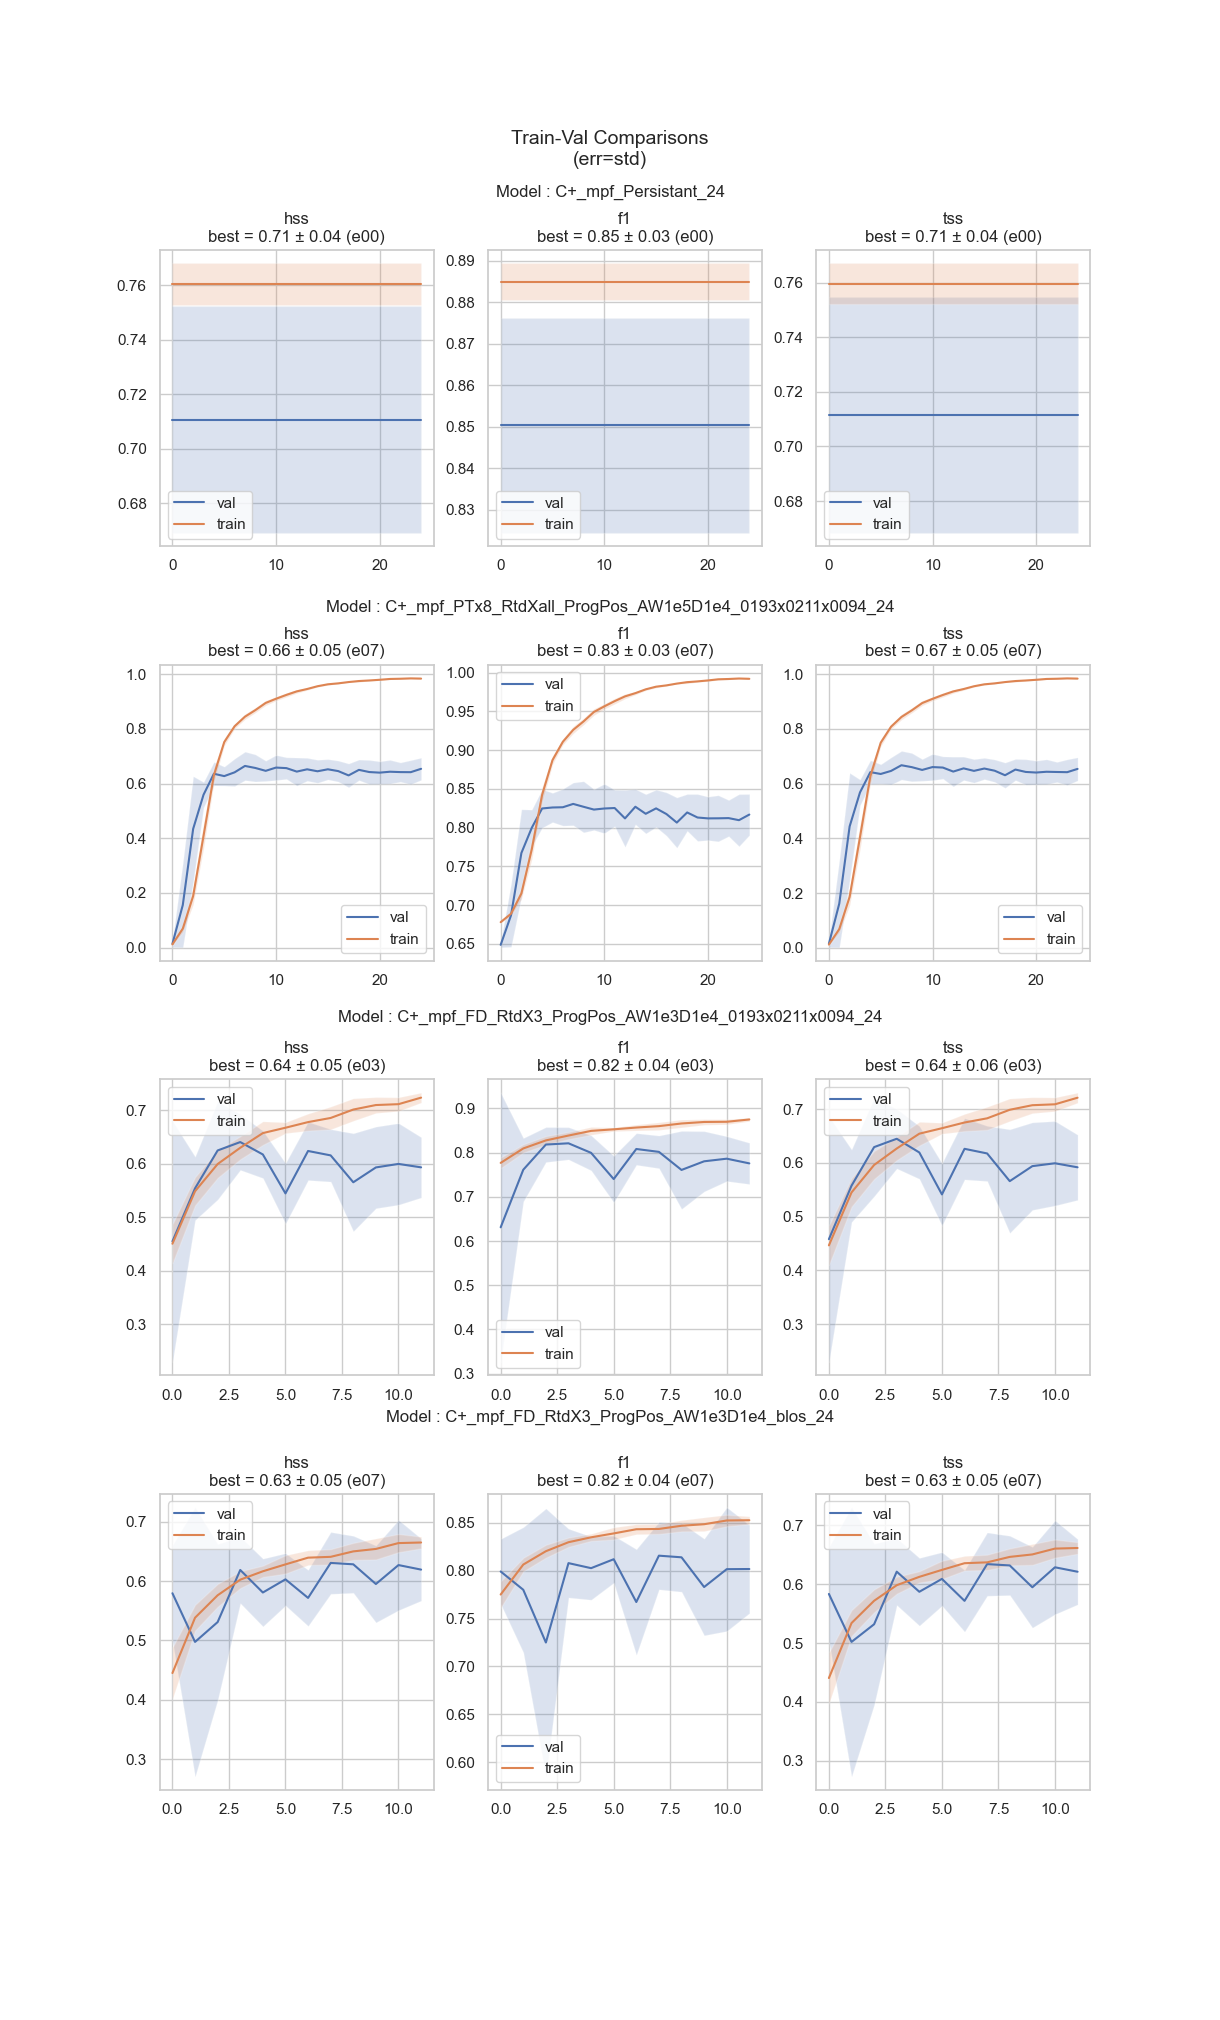

In [31]:
types    = ['C+']
hasCV    = True
num_top  = 4
alpherr  = 0.15
archis   = 'PCNN - FD -  Peristent'

err_type =  'std'# err_type # 'std' , 'minmax' (used for cv only)

plt.rcParams['figure.figsize'] = [12, 20]


metrics = ['hss','f1', 'tss']
  
tmp = best.copy()
if num_top is None: num_top = len(tmp)

sub_models = [m for m in tmp['model'].values if m[:2] in types]
sub_models = sub_models[0:num_top]


num_metrics = len(metrics)

fig, axs = plt.subplots(nrows=num_top, ncols=num_metrics, constrained_layout=False,
                         gridspec_kw={'wspace': 0.2, 'hspace': 0.4})
# fig(figsize=(15, 30))
gridspec = axs[0,0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for j,model in enumerate(sub_models):
  for i in range(num_metrics):
    mtc = metrics[i]
    ax = axs[j,i]
    val = np.array(res[model]['val_'+mtc])
    if len(val[~np.isnan(val)])==0:
      print(f'WARNING : no data for {model} {metrics[i]}')
    else:
      train = np.array(res[model][mtc])
      for idx,curve in enumerate([val, train]):
        preffix = 'val_' if idx==0 else ''
        label   = 'val' if idx==0 else 'train'
        ax.plot(curve, label=label)
        if hasCV:
          if err_type == 'minmax': err_type = ('min','max')
          if type(err_type) in [tuple,list]:
            lower = np.array(res[model][preffix+mtc+'_'+err_type[0]])
            upper = np.array(res[model][preffix+mtc+'_'+err_type[1]])
            #lower = lower[~np.isnan(lower)]
            #upper = upper[~np.isnan(upper)]
          else:
            yerr=tmp[metrics[0]+'_'+err_type], tmp[metrics[1]+'_'+err_type]
            err = np.array(res[model][preffix+mtc+'_'+err_type])
            #err = err[~np.isnan(err)]
            lower = curve - err
            upper = curve + err
          ax.fill_between(
            range(len(curve)),
            lower,
            upper,
            alpha=0.2)
      val = val[~np.isnan(val)]
      if mtc in ['loss','far','mae','mse']:
        bestmtc = np.min(val)
        bestepc = int(np.argmin(val))
      else:
        bestmtc = np.max(val)
        bestepc = int(np.argmax(val))
      if hasCV:
        if err_type == 'minmax': err_type = ('min','max')
        if type(err_type) in [tuple,list]:
          low = res[model]['val_'+mtc+'_'+err_type[0]][bestepc]
          up  = res[model]['val_'+mtc+'_'+err_type[1]][bestepc]
          extratitle = f' <{low:.2f};{up:.2f}>'
        else:
          std = res[model]['val_'+mtc+'_'+err_type][bestepc]
          extratitle = f' ± {std:.2f}'
        extratitle += f' (e{bestepc:0>2})'
      else:
        extratitle = f' at epoch  {bestepc}'
      ax.set_title(f'{mtc}\nbest = {bestmtc:.2f}{extratitle}')
      ax.legend()
      #plt.axis("off")
  extratitle = f'\n(err={str(err_type)})' if hasCV else ''
  
  vShift = np.ones(num_top)
  vShift[0] = 0.65
  vShift[1] = 0.82
  vShift[3] = 1.2
  subfigs[(j)*num_metrics + 1].suptitle(f'Model : {model}', y = vShift[j], fontsize=12)
plt.suptitle(f'Train-Val Comparisons{extratitle}', y = 0.94, fontsize=14)

## Model Zoom

CPU times: user 97.4 ms, sys: 6.48 ms, total: 104 ms
Wall time: 116 ms


Text(0.5, 0.94, 'Model : C+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193x0211x0094_24\n(err=std)')

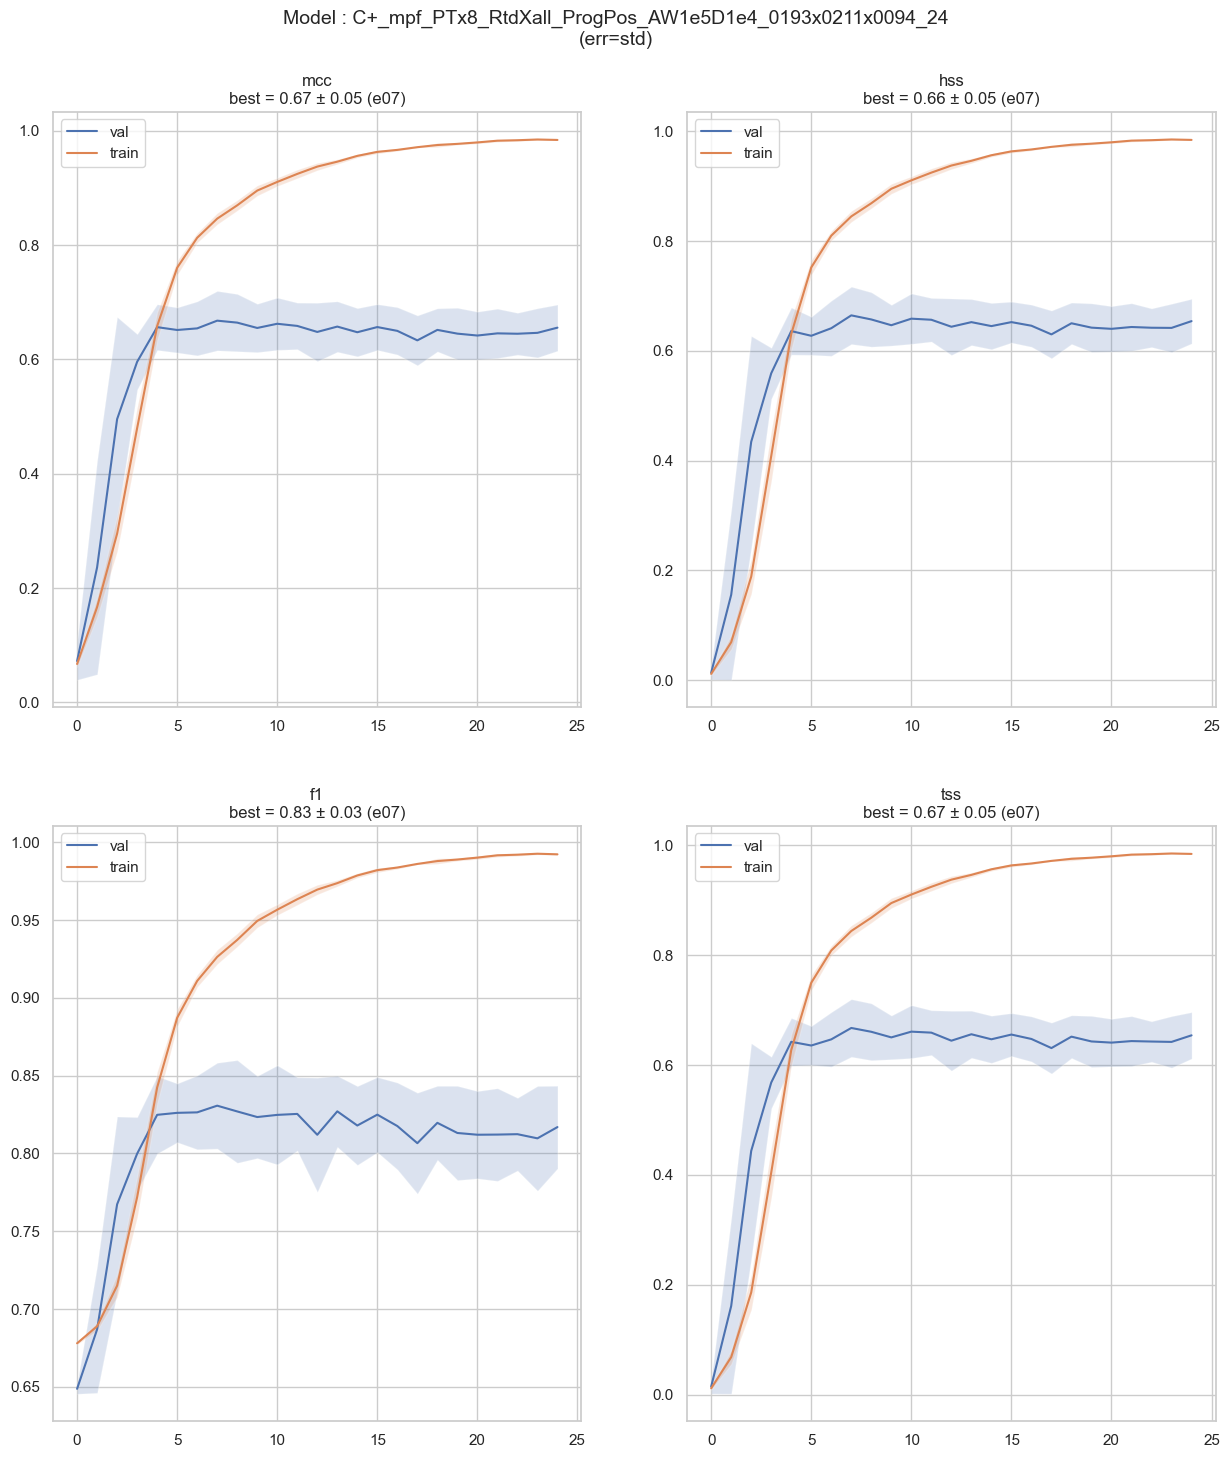

In [32]:
%%time

model =  'best'
# model = 'M+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193x0211x0094_24'
# model = 'M+_mpf_PTx8_RtdXall_LowC_AW6e6D1e3_blos_24'

err_type =  'std'# err_type # 'std' , 'minmax' (used for cv only)

plt.figure(figsize=(15, 17))

metrics = ['mcc'  ,'hss','f1', 'tss']
  

if model=='best': 
  model = best.sort_values(by=['val_tss'],ascending=False)['model'].iloc[1] # skiping persistent
num_metrics = len(metrics)
for i in range(num_metrics):
  mtc = metrics[i]
  ax = plt.subplot(int(np.ceil(np.sqrt(num_metrics))), int(np.round(np.sqrt(num_metrics))), i + 1)
  val = np.array(res[model]['val_'+mtc])
  if len(val[~np.isnan(val)])==0:
    print(f'WARNING : no data for {model} {metrics[i]}')
  else:
    train = np.array(res[model][mtc])
    for idx,curve in enumerate([val, train]):
      preffix = 'val_' if idx==0 else ''
      label   = 'val' if idx==0 else 'train'
      ax.plot(curve, label=label)
      if hasCV:
        if err_type == 'minmax': err_type = ('min','max')
        if type(err_type) in [tuple,list]:
          lower = np.array(res[model][preffix+mtc+'_'+err_type[0]])
          upper = np.array(res[model][preffix+mtc+'_'+err_type[1]])
          #lower = lower[~np.isnan(lower)]
          #upper = upper[~np.isnan(upper)]
        else:
          yerr=best[metrics[0]+'_'+err_type], best[metrics[1]+'_'+err_type]
          err = np.array(res[model][preffix+mtc+'_'+err_type])
          #err = err[~np.isnan(err)]
          lower = curve - err
          upper = curve + err
        ax.fill_between(
          range(len(curve)),
          lower,
          upper,
          alpha=0.2)
    val = val[~np.isnan(val)]
    if mtc in ['loss','far','mae','mse']:
      bestmtc = np.min(val)
      bestepc = int(np.argmin(val))
    else:
      bestmtc = np.max(val)
      bestepc = int(np.argmax(val))
    if hasCV:
      if err_type == 'minmax': err_type = ('min','max')
      if type(err_type) in [tuple,list]:
        low = res[model]['val_'+mtc+'_'+err_type[0]][bestepc]
        up  = res[model]['val_'+mtc+'_'+err_type[1]][bestepc]
        extratitle = f' <{low:.2f};{up:.2f}>'
      else:
        std = res[model]['val_'+mtc+'_'+err_type][bestepc]
        extratitle = f' ± {std:.2f}'
      extratitle += f' (e{bestepc:0>2})'
    else:
      extratitle = f' at epoch  {bestepc}'
    ax.set_title(f'{mtc}\nbest = {bestmtc:.2f}{extratitle}')
    ax.legend()
    #plt.axis("off")
extratitle = f'\n(err={str(err_type)})' if hasCV else ''
plt.suptitle(f'Model : {model}{extratitle}', y = 0.94, fontsize=14)